In [1]:
import os
import datetime
import pandas as pd
import dtale
import numpy as np
from scipy.cluster import hierarchy
import tensorflow as tf
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import predictor

np.random.seed(5981)

plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'dejavusans',
    'font.serif': ['simsun', 'AR PL UMing CN'],
    'axes.unicode_minus': False,
})

In [59]:
prefix = r'D:\git\zhongguoyuyan\csv'
location = pd.read_csv(os.path.join(prefix, 'dialect', 'location.csv'), index_col=0).sample(100)
char = pd.read_csv(os.path.join(prefix, 'words.csv'), index_col=0).sample(200)

data = predictor.load_data(os.path.join(prefix, 'dialect'), location.index)
data = data[data['iid'].isin(char.index)].sample(10000)

2022-03-13 11:21:44,668 - WARNING  - replace Ǿ -> ∅ 9128
2022-03-13 11:21:44,670 - WARNING  - replace ʦ -> ts 183
2022-03-13 11:21:44,671 - WARNING  - replace ʨ -> tɕ 137
2022-03-13 11:21:44,671 - WARNING  - replace ʦh -> tsh 137
2022-03-13 11:21:44,673 - WARNING  - replace ￻ ->  131
2022-03-13 11:21:44,673 - WARNING  - replace ø -> ∅ 91
2022-03-13 11:21:44,674 - WARNING  - replace ʨh -> tɕh 71
2022-03-13 11:21:44,674 - WARNING  - replace ¤ ->  16
2022-03-13 11:21:44,676 - WARNING  - replace g -> ɡ 5
2022-03-13 11:21:44,677 - WARNING  - replace ʔn ->  2
2022-03-13 11:21:44,677 - WARNING  - replace . ->  2
2022-03-13 11:21:44,677 - WARNING  - replace tʃhap23 ->  1
2022-03-13 11:21:44,678 - WARNING  - replace w ->  1
2022-03-13 11:21:44,678 - WARNING  - replace ŋw ->  1
2022-03-13 11:21:44,679 - WARNING  - replace ɳ ->  1
2022-03-13 11:21:44,680 - WARNING  - replace ʔŋ ->  1
2022-03-13 11:21:44,680 - WARNING  - replace tɕhiᴀʔ55 ->  1
2022-03-13 11:21:44,681 - WARNING  - replace tçh ->  1

In [3]:
dtale.show(location)

In [4]:
dtale.show(char)

In [61]:
dialects = data['oid'].unique()
chars = data['iid'].astype(str).unique()
initials = data['initial'].unique()

In [62]:
dp = predictor.AttentionPredictor(
    dialects,
    chars,
    (initials,),
    dialect_emb_size=10,
    char_emb_size=10,
    transform_heads=1,
    transform_size=20,
    optimizer=tf.keras.optimizers.Adam(0.02)
)

In [63]:
dataset = tf.data.Dataset.from_tensor_slices((
    data[['oid', 'iid']].astype(str).values,
    data[['initial']].values
))
train_data = dataset.skip(1000)
eval_data = dataset.take(1000)

In [64]:
output_path = os.path.join(
    'tensorboard',
    dp.name,
    datetime.datetime.now().strftime('%Y%m%d%H%M')
)

dp.train(train_data, eval_data, output_path=output_path)

In [24]:
manager = tf.train.CheckpointManager(dp, os.path.join(output_path, 'checkpoints'), max_to_keep=10)

steps = []
dialect_embs = []
char_embs = []
dest_embs = []
target_embs = [list() for _ in dp.target_embs]

for ckpt in manager.checkpoints:
    checkpoint.restore(ckpt)
    steps.append(checkpoint.step.numpy())
    dialect_embs.append(dp.dialect_emb.numpy())
    char_embs.append(dp.char_emb.numpy())
    dest_embs.append(dp.transform(dp.get_dialect_emb(data['oid'].values), dp.get_char_emb(data['iid'].values)).numpy())
    for i, e in enumerate(dp.target_embs):
        target_embs[i].append(e.numpy())
    
steps = np.stack(steps)
dialect_embs = np.stack(dialect_embs)
char_embs = np.stack(char_embs)
dest_embs = np.stack(dest_embs)
target_embs = [np.stack(e) for e in target_embs]

NameError: name 'checkpoint' is not defined

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

x = np.repeat(steps, dialect_embs.shape[1] * dialect_embs.shape[2])
y = dialect_embs.flatten()
if x.shape[0] > 10000:
    idx = np.random.choice(np.arange(x.shape[0]), 10000, replace=False)
    x = x[idx]
    y = y[idx]
    
sns.lineplot(x=x, y=y, ax=ax1)
ax1.set_title('dialect embbedding')

x = np.repeat(steps, char_embs.shape[1] * char_embs.shape[2])
y = char_embs.flatten()
idx = np.random.choice(np.arange(x.shape[0]), 10000, replace=False)
sns.lineplot(x=x[idx], y=y[idx], ax=ax2)

x = np.repeat(steps, dest_embs.shape[1] * dest_embs.shape[2])
y = dest_embs.flatten()
idx = np.random.choice(np.arange(x.shape[0]), 10000, replace=False)
sns.lineplot(x=x[idx], y=y[idx], ax=ax2)
ax2.set_title('character embedding')

plt.show()

fig, axes = plt.subplots(len(target_embs), 1, squeeze=False)
fig.set_size_inches(8, 6 * len(target_embs))

for i, emb in enumerate(target_embs):
    x = np.repeat(steps, emb.shape[1] * emb.shape[2])
    y = emb.flatten()
    if x.shape[0] > 10000:
        idx = np.random.choice(np.arange(x.shape[0]), 10000, replace=False)
        x = x[idx]
        y = y[idx]
        
    sns.lineplot(x=x, y=y, ax=axes[i, 0])
    axes[i, 0].set_title('target embedding {}'.format(i))
    
plt.show()

In [10]:
dialect_emb = dp.dialect_emb.numpy()
dialect_pca = PCA(2).fit(dialect_emb)
dialect_pc = dialect_pca.transform(dialect_emb)
char_emb = dp.char_emb.numpy()
char_pca = PCA(2).fit(char_emb)
char_pc = char_pca.transform(char_emb)

initial_emb = dp.target_embs[0].numpy()
initial_pc = char_pca.transform(initial_emb[:, :10])
initial_dialect_pc = dialect_pca.transform(initial_emb[:, :10])

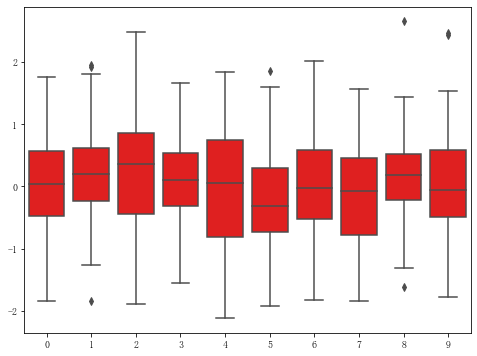

In [11]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=initial_emb, color='red')
plt.show()

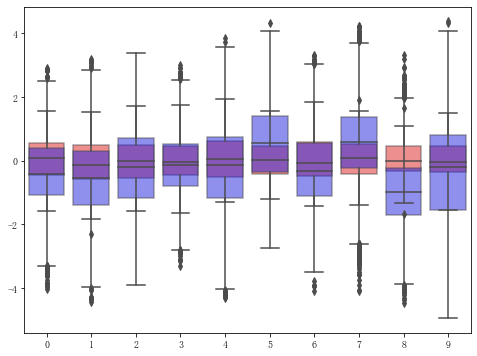

In [12]:
dest_emb = dp.transform(dp.get_dialect_emb(data['oid'].values), dp.get_char_emb(data['iid'].values))

plt.figure(figsize=(8, 6))
sns.boxplot(data=char_emb, color='red', boxprops={'alpha': 0.5})
sns.boxplot(data=dest_emb, color='blue', boxprops={'alpha': 0.5})
plt.show()

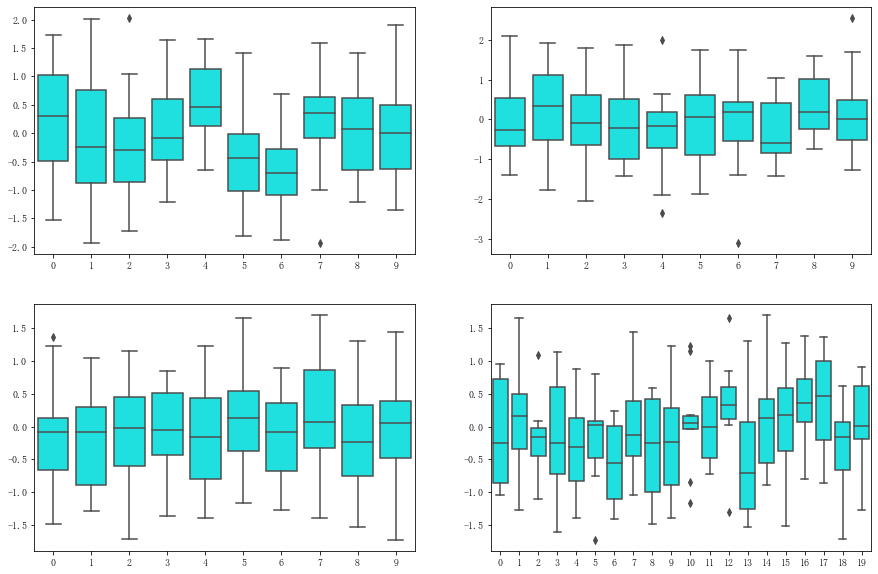

In [13]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.boxplot(data=tf.reshape(dp.dialect_att_weight, [-1, daw.shape[-1]]).numpy().T, color='cyan')
plt.subplot(2, 2, 2)
sns.boxplot(data=tf.reshape(dp.char_att_weight, [-1, caw.shape[-1]]).numpy().T, color='cyan')
plt.subplot(2, 2, 3)
sns.boxplot(data=tf.reshape(dp.trans_weight, [-1, tw.shape[-1]]).numpy(), color='cyan')
plt.subplot(2, 2, 4)
sns.boxplot(data=tf.reshape(dp.trans_weight, [-1, tw.shape[-1]]).numpy().T, color='cyan')
plt.show()

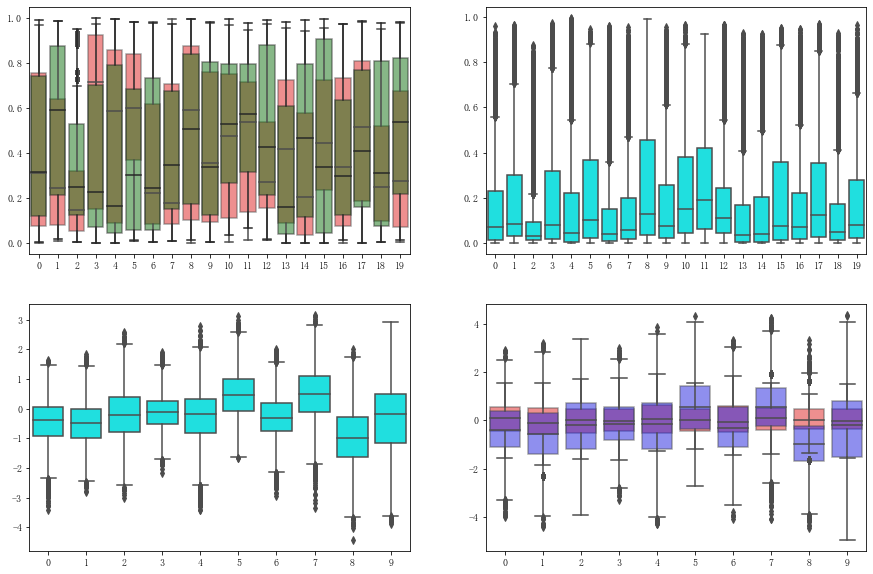

In [14]:
input_dialect_emb = dp.get_dialect_emb(data['oid'])
emb = dp.get_char_emb(data['iid'])
for daw, dab, caw, cab, tw in zip(dp.dialect_att_weights, dp.dialect_att_biases, dp.char_att_weights, dp.char_att_biases, dp.trans_weights):
    dialect_att = dp.dialect_att(input_dialect_emb, daw, dab)
    char_att = dp.char_att(emb, caw, cab)
    att = dialect_att * char_att
    trans = tf.tensordot(att, tw, [[1, 2], [0, 1]])
    
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    sns.boxplot(data=tf.reshape(dialect_att, [dialect_att.shape[0], -1]).numpy(), color='red', boxprops={'alpha': 0.5})
    sns.boxplot(data=tf.reshape(char_att, [char_att.shape[0], -1]).numpy(), color='green', boxprops={'alpha': 0.5})
    plt.subplot(2, 2, 2)
    sns.boxplot(data=tf.reshape(att, [att.shape[0], -1]).numpy(), color='cyan')
    plt.subplot(2, 2, 3)
    sns.boxplot(data=trans.numpy(), color='cyan')
    plt.subplot(2, 2, 4)
    sns.boxplot(data=emb.numpy(), color='red', boxprops={'alpha': 0.5})
    emb += trans
    sns.boxplot(data=emb.numpy(), color='blue', boxprops={'alpha': 0.5})
    plt.show()

In [15]:
linkage = hierarchy.average(dp.dialect_emb[:-1])
dialect_leaves = hierarchy.leaves_list(linkage)

linkage = hierarchy.average(dp.char_emb[:-1])
char_leaves = hierarchy.leaves_list(linkage)

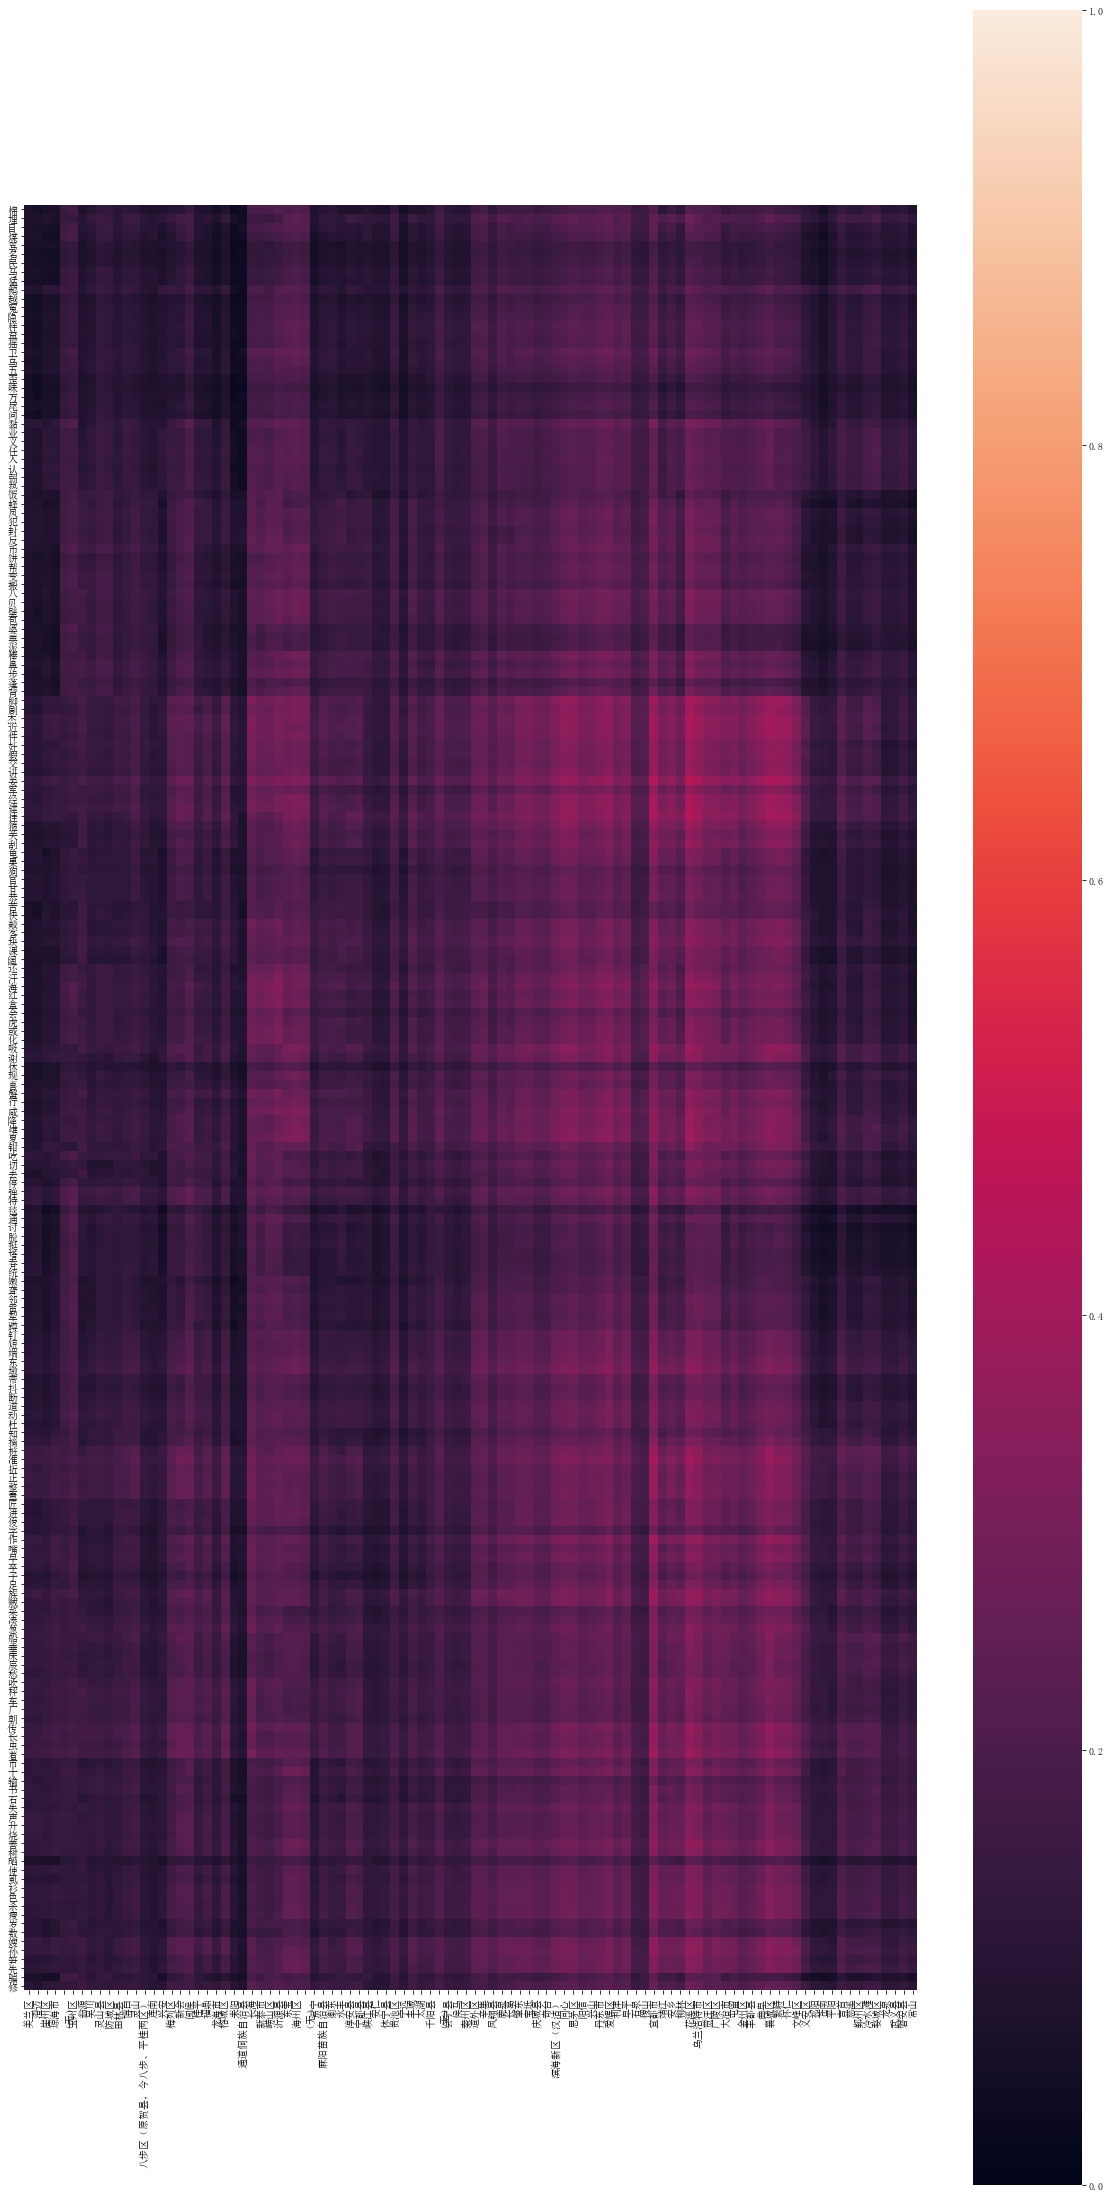

In [16]:
att = tf.reshape(
    dp.dialect_att(
        tf.repeat(dp.dialect_emb[:-1], dp.char_emb.shape[0] - 1, axis=0),
        dp.dialect_att_weights[0],
        dp.dialect_att_biases[0]
    ) * dp.char_att(
        tf.tile(dp.char_emb[:-1], [dp.dialect_emb.shape[0] - 1, 1]),
        dp.char_att_weights[0],
        dp.char_att_biases[0]
    ),
    [dp.dialect_emb.shape[0] - 1, dp.char_emb.shape[0] - 1, -1]
)

plt.figure(figsize=(20, 40))
sns.heatmap(
    tf.transpose(tf.gather(
        tf.gather(
            tf.reduce_mean(tf.reshape(att, [att.shape[0], att.shape[1], -1]), axis=-1),
            dialect_leaves,
            axis=0
        ),
        char_leaves,
        axis=1
    )),
    vmin=0,
    vmax=1,
    square=True,
    xticklabels=location.loc[dialects[dialect_leaves], 'country'],
    yticklabels=char.loc[chars.astype(int)[char_leaves], 'item']
)
plt.show()

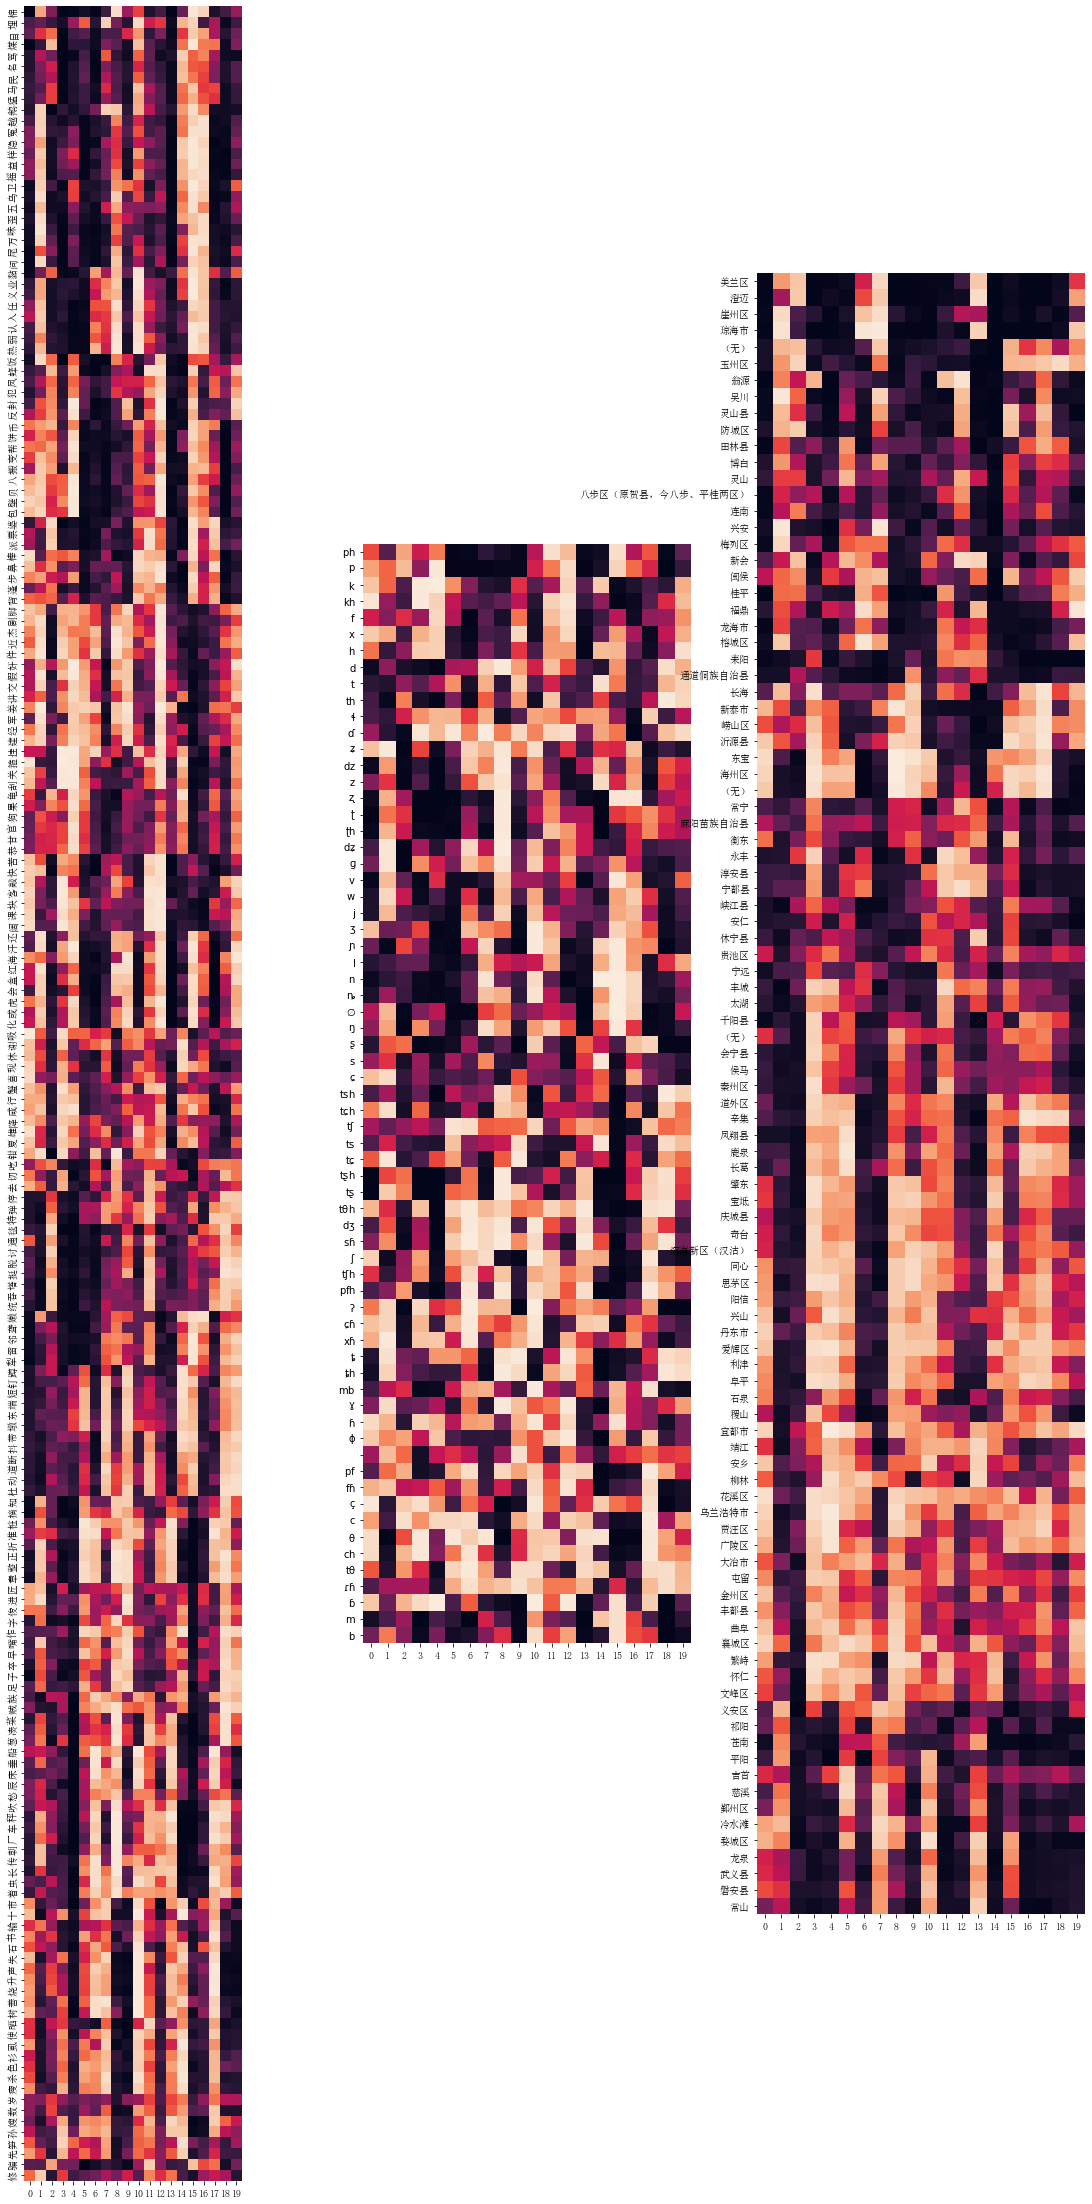

In [17]:
plt.figure(figsize=(20, 40))

att = tf.stack([dp.char_att(dp.char_emb[:-1], aw, ab) for aw, ab in zip(dp.char_att_weights, dp.char_att_biases)], axis=1)

plt.subplot(1, 3, 1)
sns.heatmap(
    tf.gather(tf.reshape(att, [att.shape[0], -1]), char_leaves, axis=0),
    vmin=0,
    vmax=1,
    cbar=False,
    square=True,
    yticklabels=char.loc[chars.astype(int)[char_leaves], 'item']
)

linkage = hierarchy.average(initial_emb)
initial_leaves = hierarchy.leaves_list(linkage)
att = tf.stack([dp.char_att(dp.target_embs[0], aw, ab) for aw, ab in zip(dp.char_att_weights, dp.char_att_biases)], axis=1)

plt.subplot(1, 3, 2)
sns.heatmap(
    tf.gather(tf.reshape(att, [att.shape[0], -1]), initial_leaves, axis=0),
    vmin=0,
    vmax=1,
    cbar=False,
    square=True,
    yticklabels=np.char.mod(r'$\mathrm{%s}$', initials[initial_leaves])
)

att = tf.stack([dp.dialect_att(dp.dialect_emb[:-1], dw, db) for dw, db in zip(dp.dialect_att_weights, dp.dialect_att_biases)], axis=1)

plt.subplot(1, 3, 3)
sns.heatmap(
    tf.gather(tf.reshape(att, [att.shape[0], -1]), dialect_leaves, axis=0),
    vmin=0,
    vmax=1,
    cbar=False,
    square=True,
    yticklabels=location.loc[dialects[dialect_leaves], 'country']
)

plt.show()

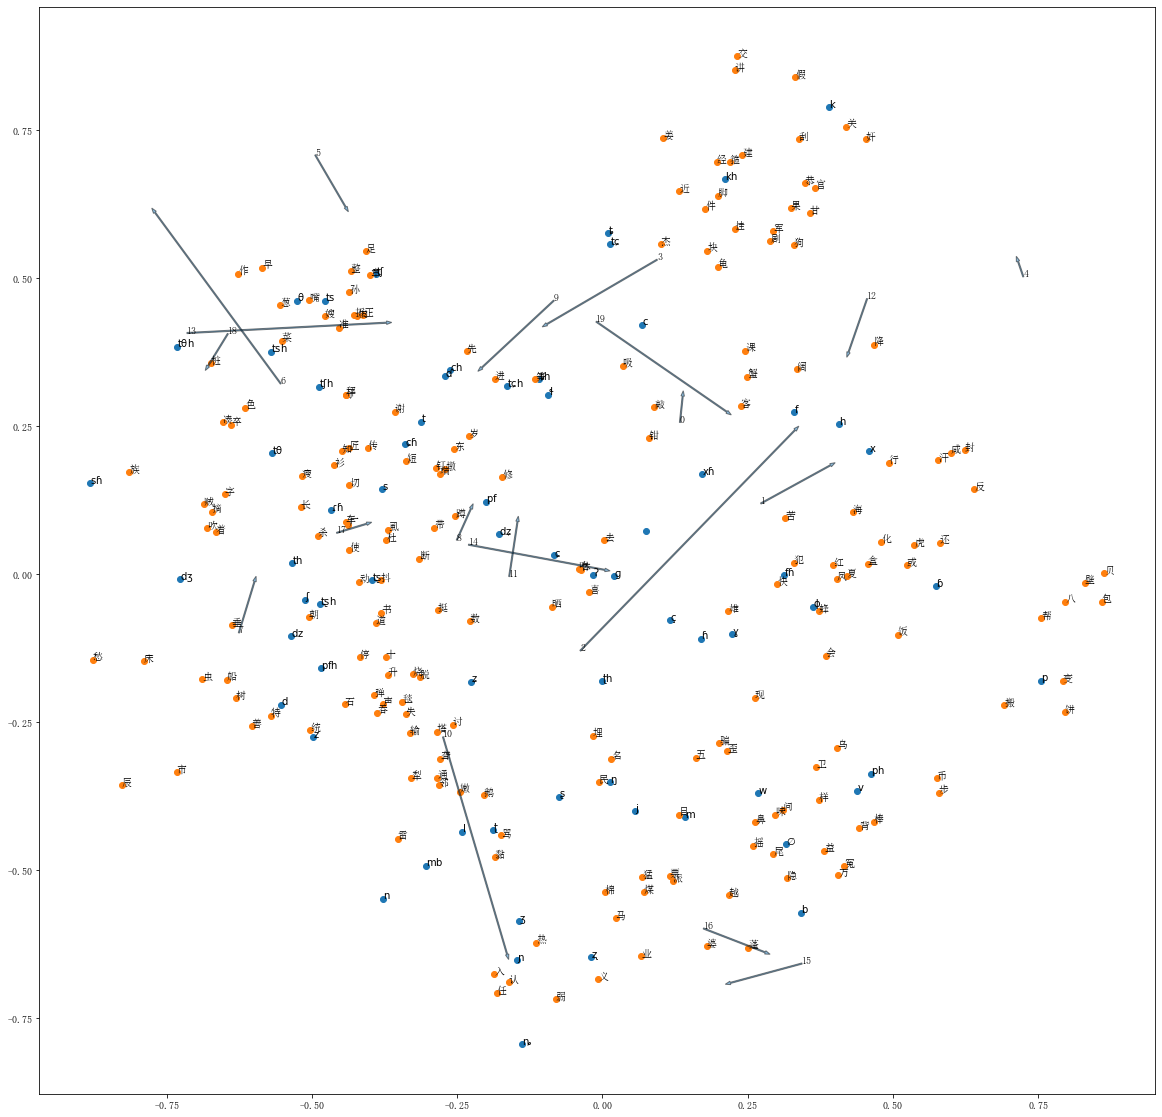

In [25]:
plt.figure(figsize=(20, 20))

char_norm_pc = char_pca.transform(tf.linalg.normalize(dp.char_emb[:-1], axis=1)[0])
initial_norm_pc = char_pca.transform(tf.linalg.normalize(dp.target_embs[0], axis=1)[0])
att_norm_pc = char_pca.transform(tf.linalg.normalize(tf.transpose(tf.reshape(dp.char_att_weights[0], [dp.char_att_weights[0].shape[0], -1])), axis=1)[0])
trans_norm_pc = char_pca.transform(tf.linalg.normalize(tf.transpose(tf.reshape(dp.char_att_weights[0], [dp.char_att_weights[0].shape[0], -1])) + tf.reshape(dp.trans_weights[0], [-1, dp.trans_weights[0].shape[-1]]), axis=1)[0])

plt.scatter(initial_norm_pc[:, 0], initial_norm_pc[:, 1])
for i, initial in enumerate(initials):
    plt.annotate(r'$\mathrm{{{}}}$'.format(initial), xy=(initial_norm_pc[i, 0], initial_norm_pc[i, 1]))
    
plt.scatter(char_norm_pc[:, 0], char_norm_pc[:, 1])
for i, cid in enumerate(chars.astype(int)):
    plt.annotate(char.loc[cid, 'item'], xy=(char_norm_pc[i, 0], char_norm_pc[i, 1]))

for i in range(trans_norm_pc.shape[0]):
    plt.arrow(att_norm_pc[i, 0], att_norm_pc[i, 1], trans_norm_pc[i, 0] - att_norm_pc[i, 0], trans_norm_pc[i, 1] - att_norm_pc[i, 1], width=0.002, alpha=0.5)
    plt.annotate(str(i), xy=(att_norm_pc[i, 0], att_norm_pc[i, 1]))
    
plt.show()

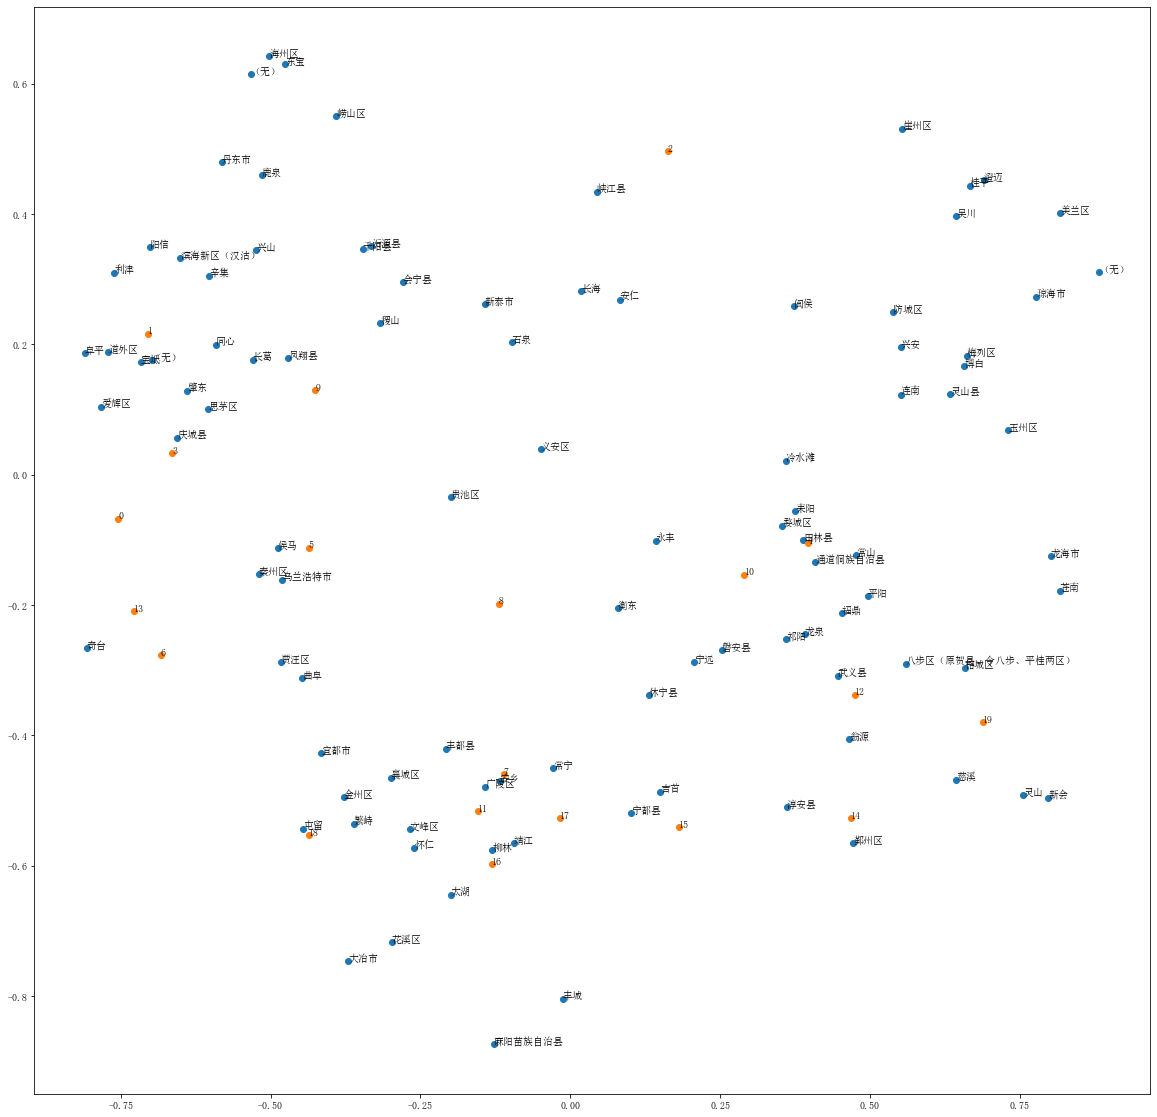

In [25]:
plt.figure(figsize=(20, 20))

dialect_norm_pc = dialect_pca.transform(tf.linalg.normalize(dp.dialect_emb[:-1], axis=1)[0])
att_norm_pc = dialect_pca.transform(tf.linalg.normalize(tf.transpose(tf.reshape(dp.dialect_att_weights[0], [dp.dialect_att_weights[0].shape[0], -1])), axis=1)[0])

plt.scatter(dialect_norm_pc[:, 0], dialect_norm_pc[:, 1])
for i, oid in enumerate(dialects):
    plt.annotate(location.loc[oid, 'country'], xy=(dialect_norm_pc[i, 0], dialect_norm_pc[i, 1]))

plt.scatter(att_norm_pc[:, 0], att_norm_pc[:, 1])
for i in range(att_norm_pc.shape[0]):
    plt.annotate(str(i), xy=(att_norm_pc[i, 0], att_norm_pc[i, 1]))
    
plt.show()

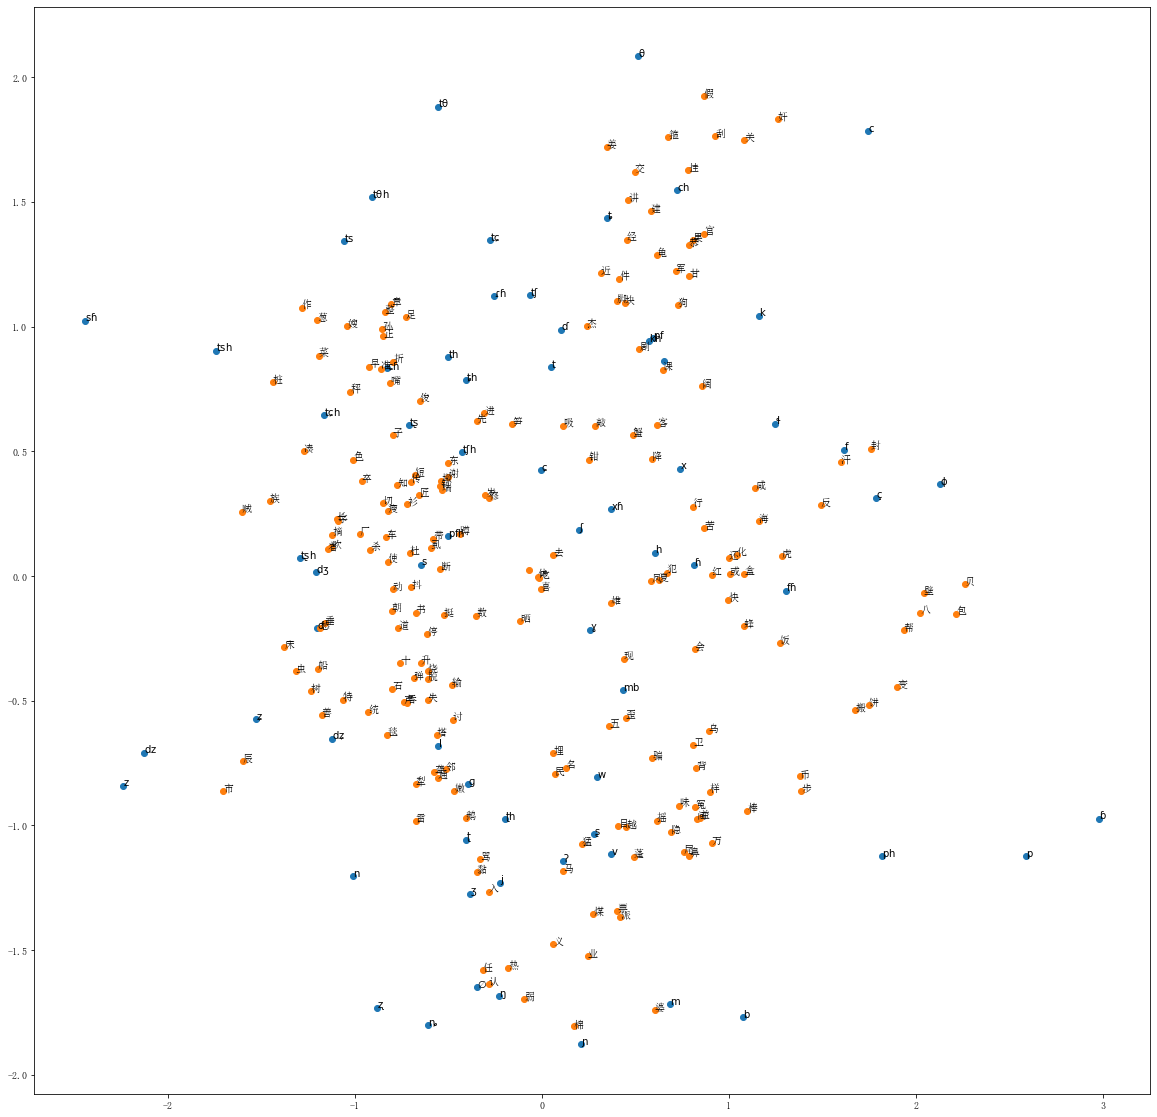

In [26]:
plt.figure(figsize=(20, 20))
    
plt.scatter(initial_pc[:, 0], initial_pc[:, 1])
for i, initial in enumerate(np.char.decode(dp.targets[0].numpy().astype(np.bytes_))):
    plt.annotate(r'$\mathrm{{{}}}$'.format(initial), xy=(initial_pc[i, 0], initial_pc[i, 1]))
    
plt.scatter(char_pc[:, 0], char_pc[:, 1])
for i, cid in enumerate(dp.chars.numpy().astype(int)):
    plt.annotate(char.loc[cid, 'item'], xy=(char_pc[i, 0], char_pc[i, 1]))
 
plt.show()

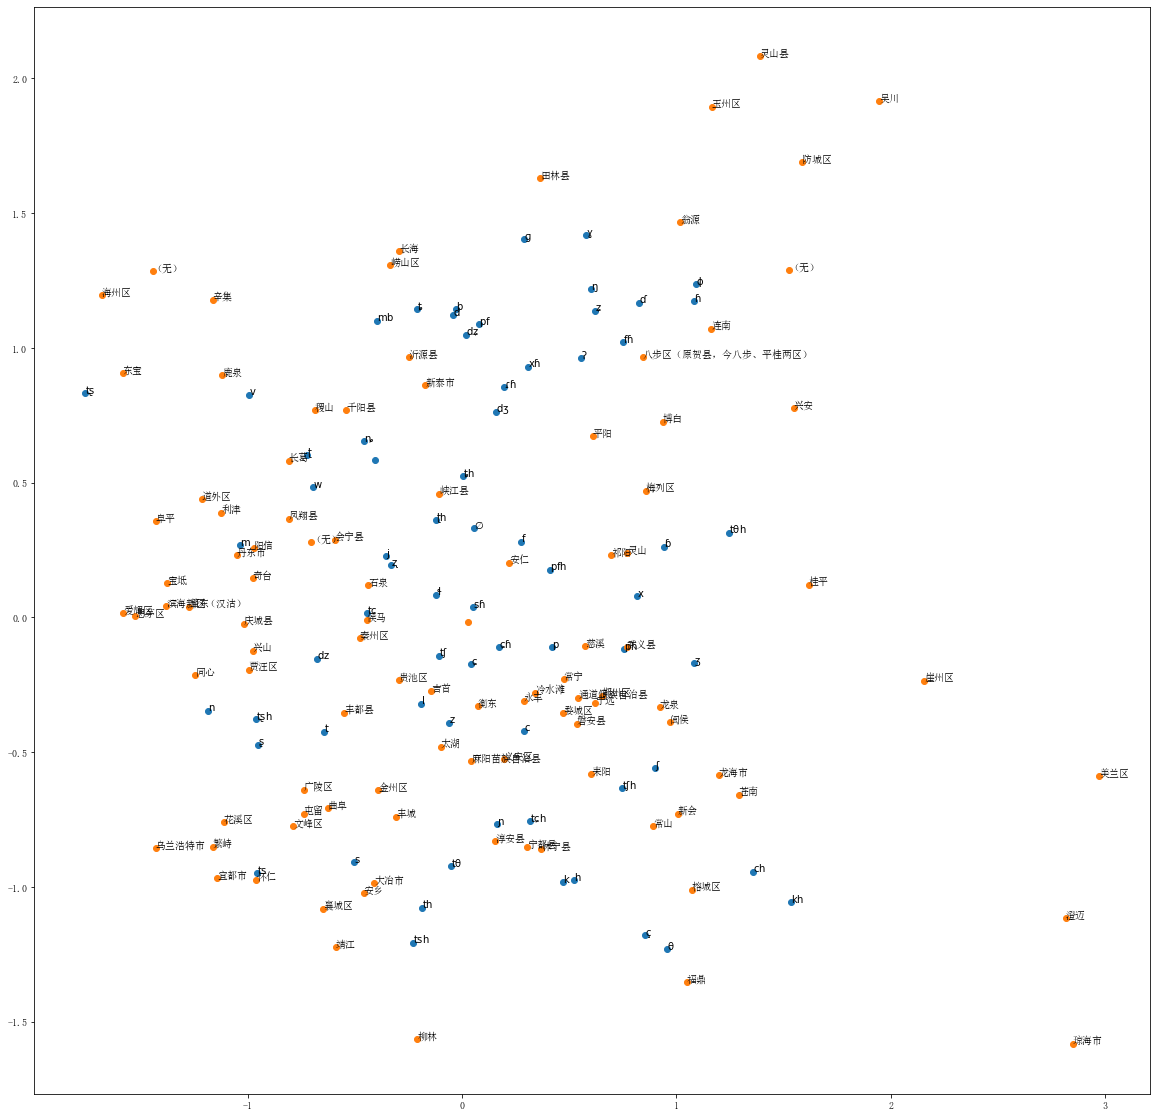

In [20]:
plt.figure(figsize=(20, 20))
    
plt.scatter(initial_dialect_pc[:, 0], initial_dialect_pc[:, 1])
for i, initial in enumerate(np.char.decode(dp.targets[0].numpy().astype(np.bytes_))):
    plt.annotate(r'$\mathrm{{{}}}$'.format(initial), xy=(initial_dialect_pc[i, 0], initial_dialect_pc[i, 1]))
    
plt.scatter(dialect_pc[:, 0], dialect_pc[:, 1])
for i, oid in enumerate(np.char.decode(dp.dialects.numpy().astype(np.bytes_))):
    plt.annotate(location.loc[oid, 'country'], xy=(dialect_pc[i, 0], dialect_pc[i, 1]))

plt.show()

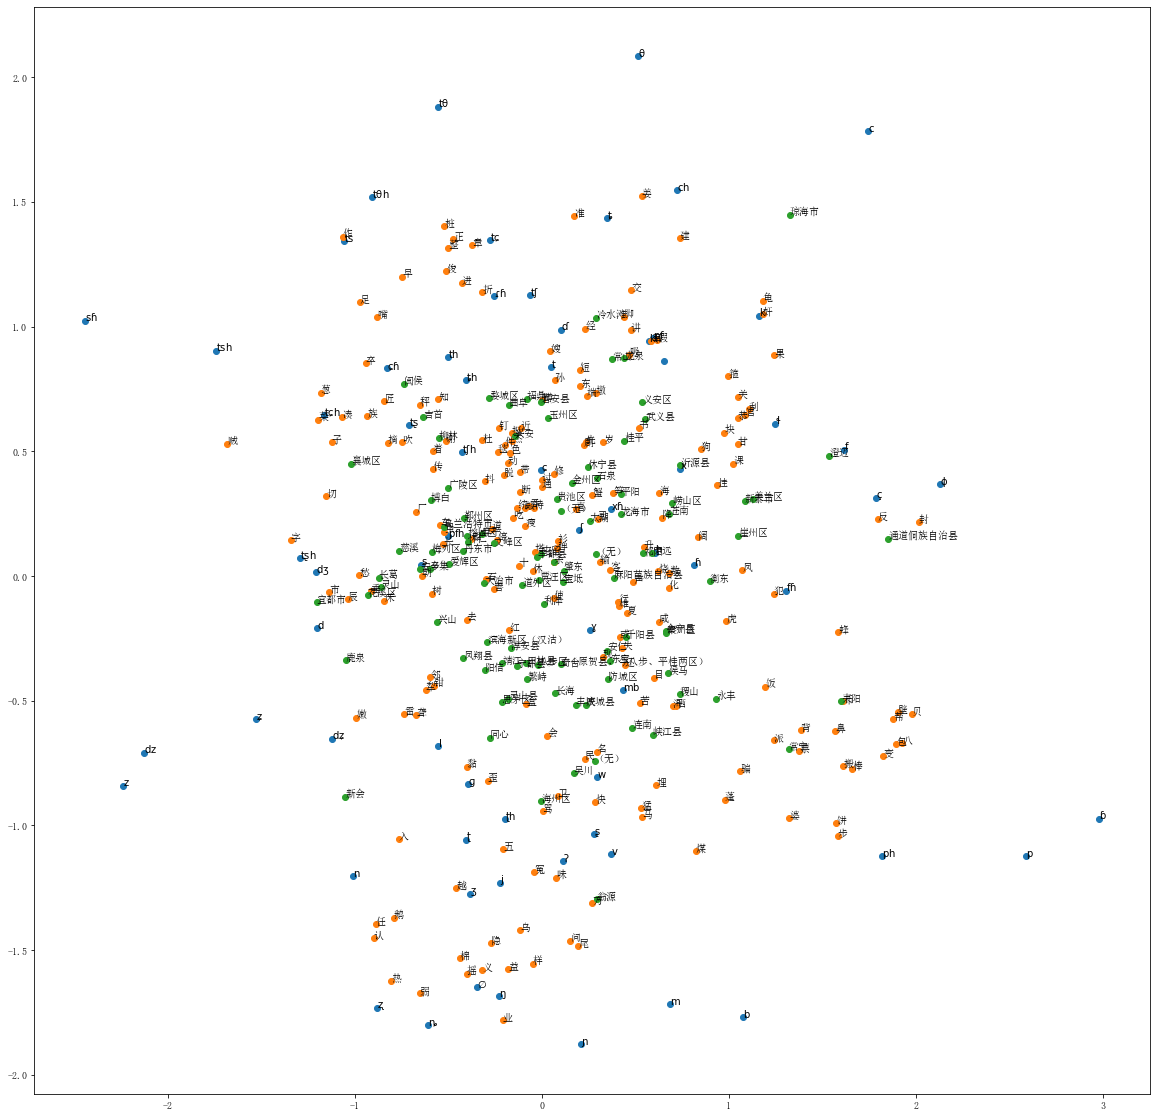

In [21]:
initial_pca = PCA(2).fit(initial_emb)
initial_pc = initial_pca.transform(initial_emb)
char_initial_pc = initial_pca.transform(char_emb)
dialect_initial_pc = initial_pca.transform(dialect_emb)

plt.figure(figsize=(20, 20))
    
plt.scatter(initial_pc[:, 0], initial_pc[:, 1])
for i, initial in enumerate(np.char.decode(dp.targets[0].numpy().astype(np.bytes_))):
    plt.annotate(r'$\mathrm{{{}}}$'.format(initial), xy=(initial_pc[i, 0], initial_pc[i, 1]))
    
plt.scatter(char_initial_pc[:, 0], char_initial_pc[:, 1])
for i, cid in enumerate(dp.chars.numpy().astype(int)):
    plt.annotate(char.loc[cid, 'item'], xy=(char_initial_pc[i, 0], char_initial_pc[i, 1]))
    
plt.scatter(dialect_initial_pc[:, 0], dialect_initial_pc[:, 1])
for i, oid in enumerate(np.char.decode(dp.dialects.numpy().astype(np.bytes_))):
    plt.annotate(location.loc[oid, 'country'], xy=(dialect_initial_pc[i, 0], dialect_initial_pc[i, 1]))

plt.show()

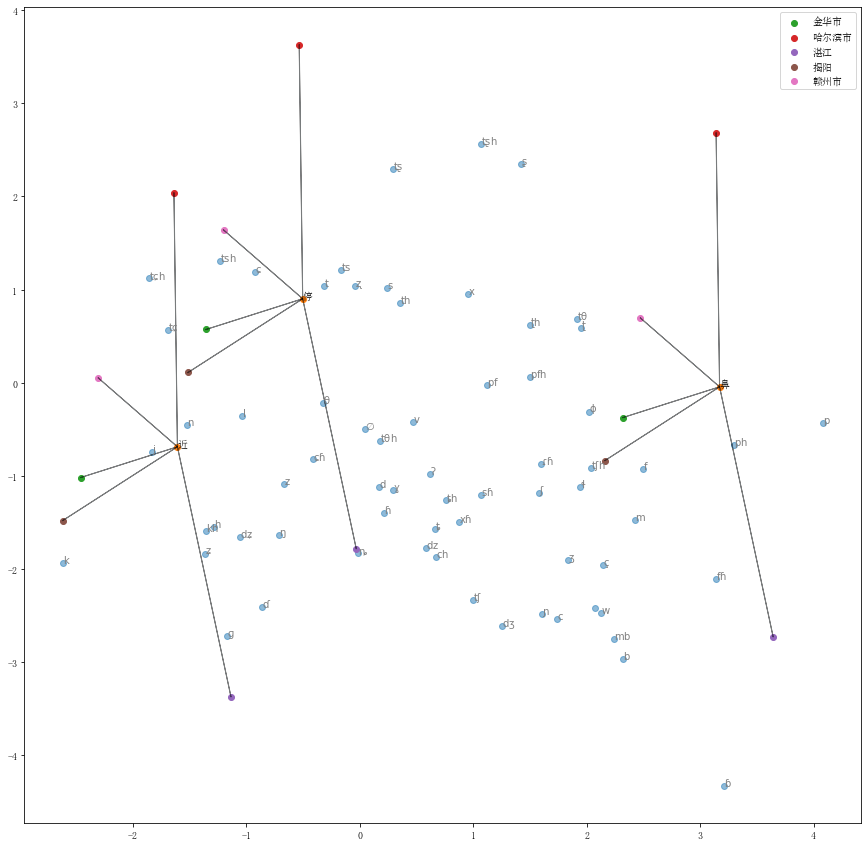

In [58]:
test_dialect = np.asarray(['08K18', '25381', '15F53', '15230', '18359'])
# test_dialect = np.asarray(['08K18', '25381', '15230', '18359'])
test_char = np.asarray(['0660', '0894', '0214'])
test_dialect_emb = dp.get_dialect_emb(test_dialect)
test_char_emb = dp.get_char_emb(test_char)
dest_emb = dp.transform(tf.repeat(test_dialect_emb, test_char_emb.shape[0], axis=0), tf.tile(test_char_emb, [test_dialect_emb.shape[0], 1]))
pca = PCA(2).fit(tf.concat([test_char_emb, dest_emb], axis=0))
test_char_pc = pca.transform(test_char_emb)
dest_pc = pca.transform(dest_emb).reshape(test_dialect.shape[0], test_char.shape[0], -1)

test_initial_pc = pca.transform(initial_emb)

plt.figure(figsize=(15, 15))

plt.scatter(test_initial_pc[:, 0], test_initial_pc[:, 1], alpha=0.5)
for i, initial in enumerate(initials):
    plt.annotate(f'$\mathrm{{{initial}}}$', xy=(test_initial_pc[i, 0], test_initial_pc[i, 1]), color='gray')
    
plt.scatter(test_char_pc[:, 0], test_char_pc[:, 1])
for i, cid in enumerate(test_char):
    plt.annotate(char.loc[int(cid), 'item'], xy=(test_char_pc[i, 0], test_char_pc[i, 1]))
    
for i in range(dest_pc.shape[0]):
    plt.scatter(dest_pc[i, :, 0], dest_pc[i, :, 1], label=location.loc[test_dialect[i], 'city'])
    
    for j in range(dest_pc.shape[1]):
        plt.arrow(test_char_pc[j, 0], test_char_pc[j, 1], dest_pc[i, j, 0] - test_char_pc[j, 0], dest_pc[i, j, 1] - test_char_pc[j, 1], alpha=0.5)

plt.legend()
plt.show()

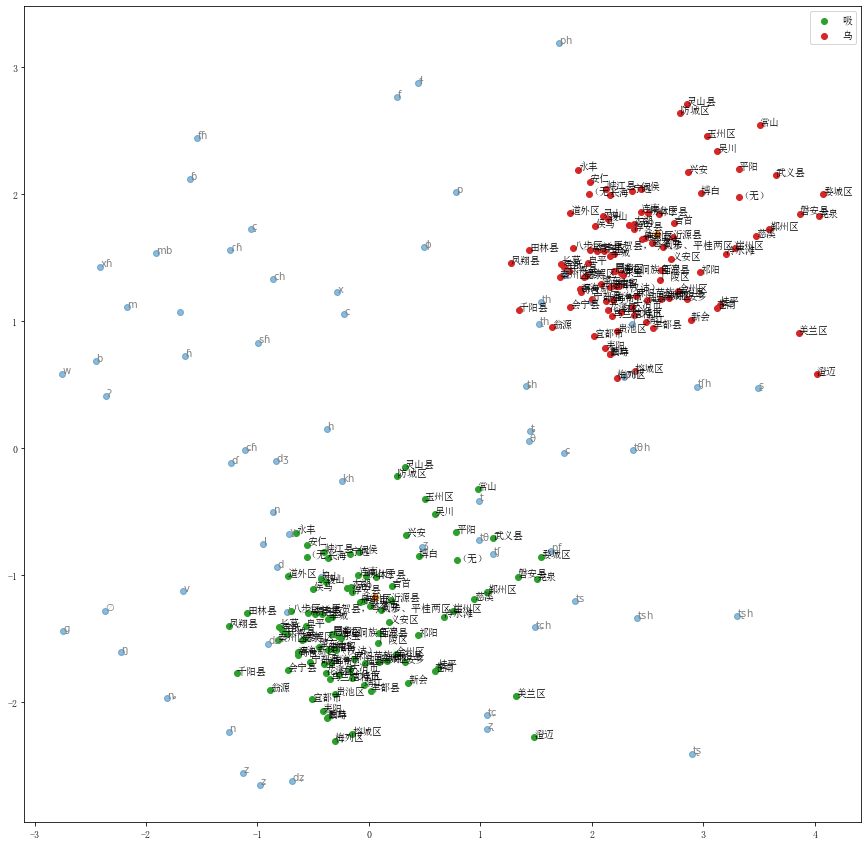

In [15]:
dest_emb = dp.transform(
    tf.repeat(dp.dialect_emb[:-1], 2, axis=0),
    tf.tile(dp.char_emb[:2], [dp.dialect_emb.shape[0] - 1, 1])
).numpy()
char_pc = char_pca.transform(char_emb)
dest_pc = char_pca.transform(dest_emb).reshape(-1, 2, 2)
dialects = np.char.decode(dp.dialects[:-1].numpy().astype(np.bytes_))
chars = char.loc[dp.chars[:2].numpy().astype(int), 'item'].values

plt.figure(figsize=(15, 15))

plt.scatter(initial_pc[:, 0], initial_pc[:, 1], alpha=0.5)
for i, initial in enumerate(np.char.decode(dp.targets[0].numpy().astype(np.bytes_))):
    plt.annotate(r'$\mathrm{{{}}}$'.format(initial), xy=(initial_pc[i, 0], initial_pc[i, 1]), color='gray')

plt.scatter(char_pc[:2, 0], char_pc[:2, 1])

for i in range(dest_pc.shape[1]):
    plt.scatter(dest_pc[:, i, 0], dest_pc[:, i, 1], label=chars[i])
    for j in range(dialects.shape[0]):
        plt.annotate(location.loc[dialects[j], 'country'], xy=(dest_pc[j, i, 0], dest_pc[j, i, 1]))

plt.legend()
plt.show()

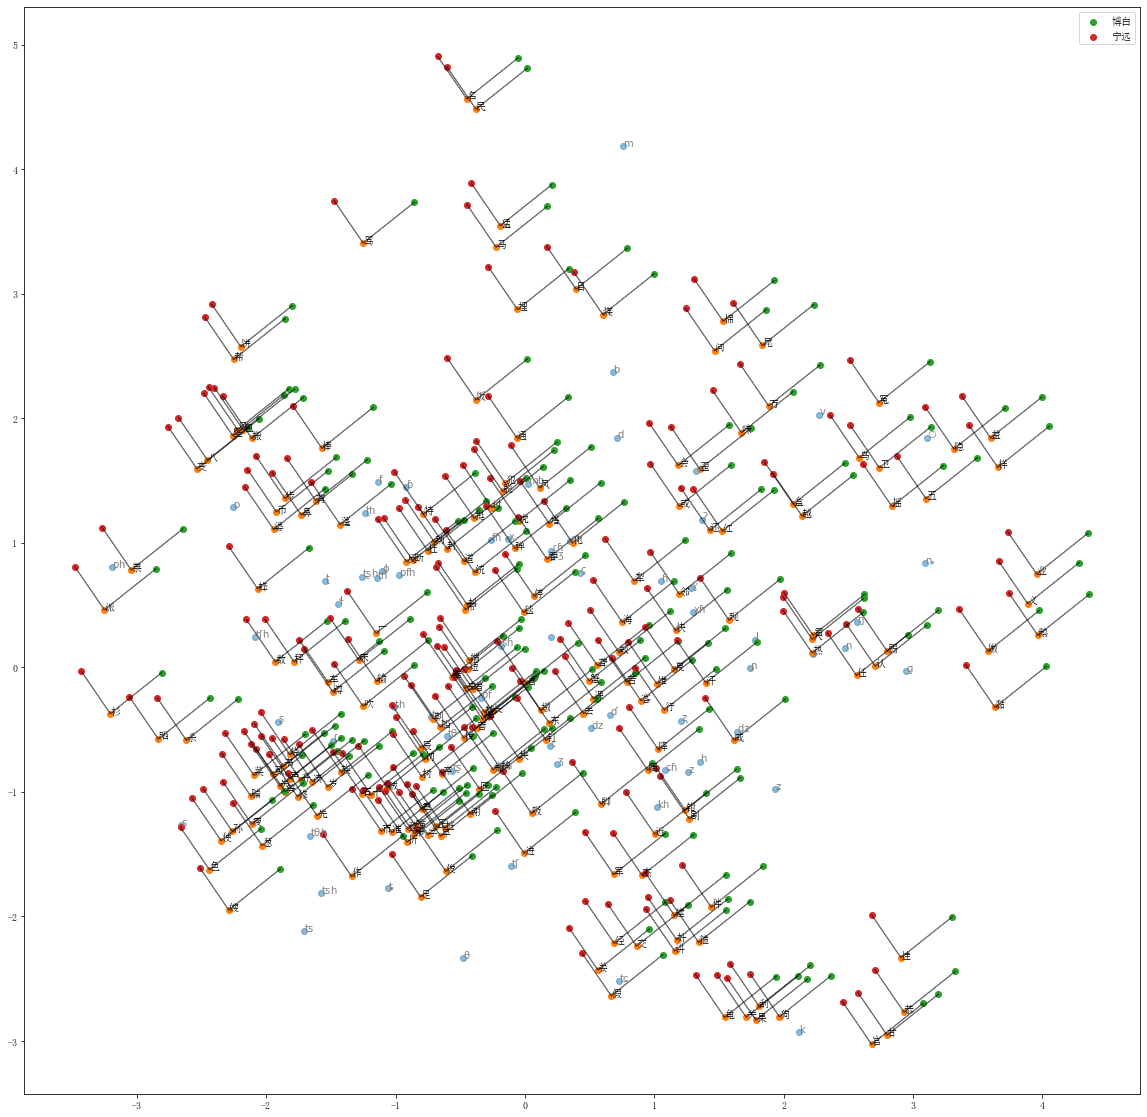

In [27]:
dest_emb = dp.transform(
    tf.repeat(dp.dialect_emb[:2], dp.char_emb.shape[0] - 1, axis=0),
    tf.tile(dp.char_emb[:-1], [2, 1])
).numpy()

dest_pc = char_pca.transform(dest_emb).reshape([2, -1, 2])

plt.figure(figsize=(20, 20))

plt.scatter(initial_pc[:, 0], initial_pc[:, 1], alpha=0.5)
for i, initial in enumerate(initials):
    plt.annotate(r'$\mathrm{{{}}}$'.format(initial), xy=(initial_pc[i, 0], initial_pc[i, 1]), color='gray')
    
plt.scatter(char_pc[:-1, 0], char_pc[:-1, 1])
for i in range(chars.shape[0]):
    plt.annotate(char.loc[int(chars[i]), 'item'], xy=(char_pc[i, 0], char_pc[i, 1]))

for i in range(dest_pc.shape[0]):
    plt.scatter(dest_pc[i, :, 0], dest_pc[i, :, 1], label=location.loc[dialects[i], 'country'])
    
    for j in range(dest_pc.shape[1]):
        plt.arrow(char_pc[j, 0], char_pc[j, 1], dest_pc[i, j, 0] - char_pc[j, 0], dest_pc[i, j, 1] - char_pc[j, 1], alpha=0.5)
        
plt.legend()
plt.show()

In [41]:
test_dialects = ['05K02', '23C85']
test_chars = ['0469', '0474', '0656']
demb = dp.get_dialect_emb(test_dialects)
cemb = dp.get_char_emb(test_chars)
emb = dp.transform(tf.repeat(demb, cemb.shape[0], axis=0), tf.tile(cemb, [demb.shape[0], 1]))
dest_emb = emb[0::3] - emb[1::3] + emb[2::3]
pred = np.char.decode(tf.stack(
    [dp.id_to_target(i, tf.argmax(tf.matmul(dest_emb, e, transpose_b=True), axis=1)) for i, e in enumerate(dp.target_embs)]
    , axis=1
).numpy().astype(np.bytes_))
display(pred)

array([['k'],
       ['k']], dtype='<U1')

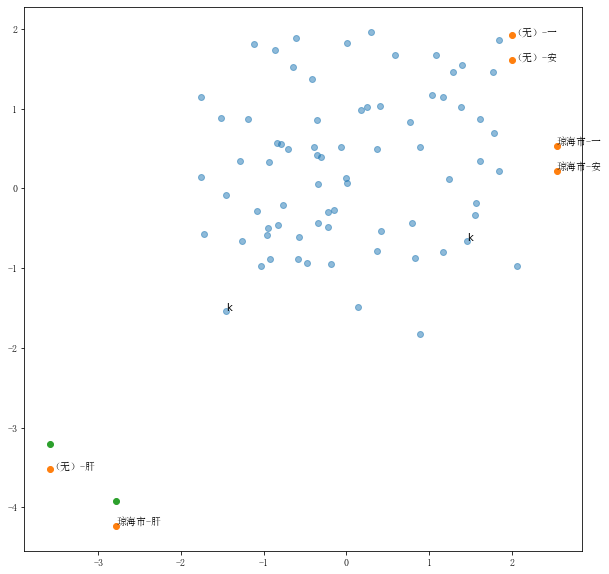

In [42]:
plt.figure(figsize=(10, 10))
plt.scatter(initial_pc[:, 0], initial_pc[:, 1], alpha=0.5)
src_pc = char_pca.transform(emb)
dest_pc = char_pca.transform(dest_emb)
plt.scatter(src_pc[:, 0], src_pc[:, 1])
plt.scatter(dest_pc[:, 0], dest_pc[:, 1])

for i in range(src_pc.shape[0]):
    plt.annotate(
        '{}-{}'.format(location.loc[test_dialects[i // 3], 'country'], char.loc[int(test_chars[i % 3]), 'item']),
        xy=(src_pc[i, 0], src_pc[i, 1])
    )
    
initial_id = dp.target_to_id(0, pred[:, 0]).numpy()
for i in range(initial_id.shape[0]):
    plt.annotate(r'$\mathrm{{{}}}$'.format(pred[i, 0]), xy=(initial_pc[i, 0], initial_pc[i, 1]))
    
plt.show()

In [43]:
demb = dp.get_dialect_emb(['05K02', '08K18'])
demb1 = demb[0]
demb2 = demb[1]
cemb = dp.get_char_emb(['0843'])[0]
w = np.arange(0, 1.1, 0.1)
demb = (1 - w[:, None]) * demb1[None, :] + w[:, None] * demb2[None, :]
emb = dp.transform(demb, tf.tile(cemb[None, :], [demb.shape[0], 1]))
pred = dp.predict_id_emb(demb, tf.tile(cemb[None, :], [demb.shape[0], 1]))
display(np.char.decode(tf.stack([dp.id_to_target(i, pred[:, i]) for i in range(pred.shape[1])], axis=1).numpy().astype(np.bytes_)))

array([['p'],
       ['p'],
       ['p'],
       ['p'],
       ['p'],
       ['p'],
       ['b'],
       ['b'],
       ['b'],
       ['b'],
       ['b']], dtype='<U1')

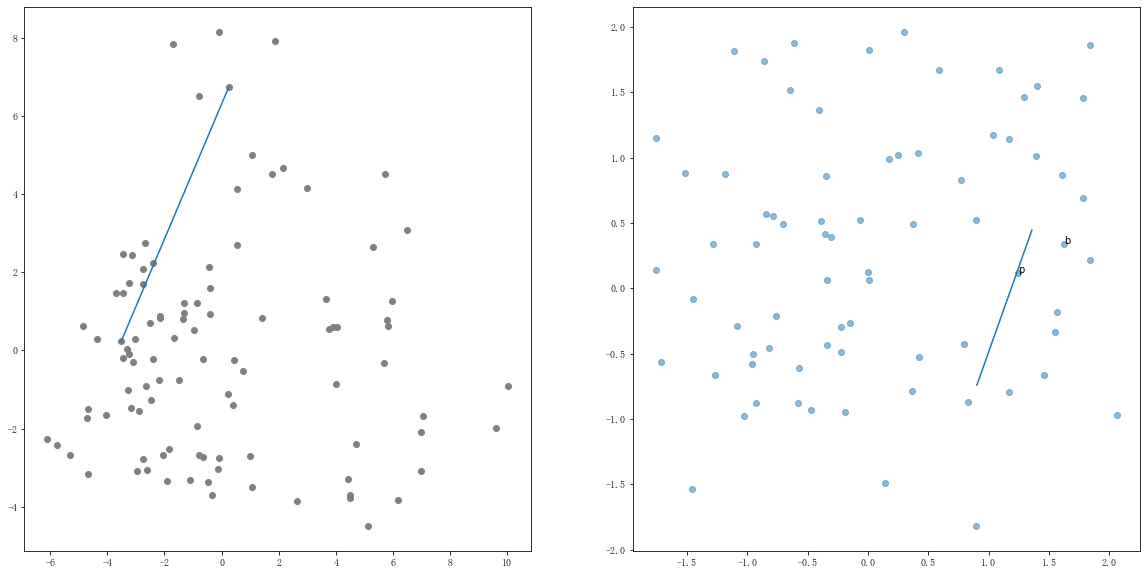

In [44]:
dialect_pca = PCA(2)
dialect_pc = dialect_pca.fit_transform(dialect_emb)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

ax1.scatter(dialect_pc[:, 0], dialect_pc[:, 1], color='gray')
src_pc = dialect_pca.transform(demb.numpy())
ax1.plot(src_pc[:, 0], src_pc[:, 1])

ax2.scatter(initial_pc[:, 0], initial_pc[:, 1], alpha=0.5)
dest_pc = char_pca.transform(emb)
ax2.plot(dest_pc[:, 0], dest_pc[:, 1])

ids = tf.unique(pred[:, 0])[0]
phones = np.char.decode(dp.id_to_target(0, ids).numpy().astype(np.bytes_))
for id, phone in zip(ids.numpy(), phones):
    ax2.annotate(r'$\mathrm{{{}}}$'.format(phone), xy=(initial_pc[id, 0], initial_pc[id, 1]))
    
plt.show()